# Mechanistic Interpretability

## 1. Find induction heads where we know they exist. 

Take a GPT-2 or LLama model, visualize the attention patterns, and find the heads that seem to be doing induction. Additionally, see if you can automatically rank the heads by how much they attend to previous tokens like induction heads on synthetic samples `A B X_1 ... X_N A`. 

## 2. Apply the same two techniques to the ICL pretrained transformer

In [1]:
import os
from dotenv import load_dotenv

load_dotenv();

In [3]:
import torch
from torch import nn

from icl.analysis.utils import get_unique_run
from icl.analysis.probes import ActivationProbe

/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [37]:
run = get_unique_run(
    "../sweeps/small-sweep.yaml", 
    task_config={"num_tasks": 4, "num_layers": 2},
    optimizer_config={"lr": 0.001}
)

/Users/Jesse/Projects/devinterp/devinterp/utils.py:46: UserWarning: Number of steps in int_logspace is not 100, got 91.
/Users/Jesse/Projects/devinterp/devinterp/utils.py:46: UserWarning: Number of steps in int_logspace is not 50, got 47.
/Users/Jesse/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/main.py:301: UserWarning: Pydantic serializer warnings:
  Expected `str` but got `device` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [38]:
# Confirm that we've loaded in the most recent model
run.evaluator(run.model)

{'pretrain/mse': 0.5319575667381287,
 'pretrain/delta_dmmse': tensor(0.0008, device='mps:0'),
 'pretrain/delta_ridge': tensor(0.9461, device='mps:0'),
 'pretrain/token/0': 2.367990493774414,
 'pretrain/token/1': 0.8282801508903503,
 'pretrain/token/2': 0.34063640236854553,
 'pretrain/token/3': 0.19457794725894928,
 'pretrain/token/4': 0.13884013891220093,
 'pretrain/token/5': 0.13344000279903412,
 'pretrain/token/6': 0.12818315625190735,
 'pretrain/token/7': 0.1237119808793068,
 'true/mse': 4.942747116088867,
 'true/delta_dmmse': tensor(0.5275, device='mps:0'),
 'true/delta_ridge': tensor(3.2877, device='mps:0'),
 'true/token/0': 5.312987804412842,
 'true/token/1': 5.986356258392334,
 'true/token/2': 5.443770408630371,
 'true/token/3': 5.033511161804199,
 'true/token/4': 4.409271240234375,
 'true/token/5': 4.354643821716309,
 'true/token/6': 4.6436262130737305,
 'true/token/7': 4.357812881469727}

In [39]:
# Ready to investigate
run.model

InContextRegressionTransformer(
  (token_sequence_transformer): DTransformer(
    (token_embedding): Linear(in_features=5, out_features=64, bias=False)
    (postn_embedding): Linear(in_features=16, out_features=64, bias=False)
    (blocks): ModuleList(
      (0-1): 2 x MultiHeadedCausalSelfAttentionTransformerBlock(
        (attention): MultiHeadedCausalSelfAttention(
          (attention): Linear(in_features=64, out_features=192, bias=False)
          (attention_softmax): Softmax(dim=-1)
        )
        (compute): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
        (layer_norms): ModuleList(
          (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (unembedding): Sequential(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=64, out_features=5, bias=True)
    )
  )
)

In [52]:
if probes:
    for probe in probes:
        probe.unregister_hook()

probes = []

for b in range(2):
    probe = ActivationProbe(run.model, f"token_sequence_transformer.blocks.{b}.attention.attention_softmax")
    probe.register_hook()
    probes.append(probe)

# Run the model
xs, ys = run.pretrain_dist.get_batch(8, 128)
run.model(xs, ys)

# Get the activations
print(probes[1].activation.shape)

torch.Size([128, 4, 16, 16])


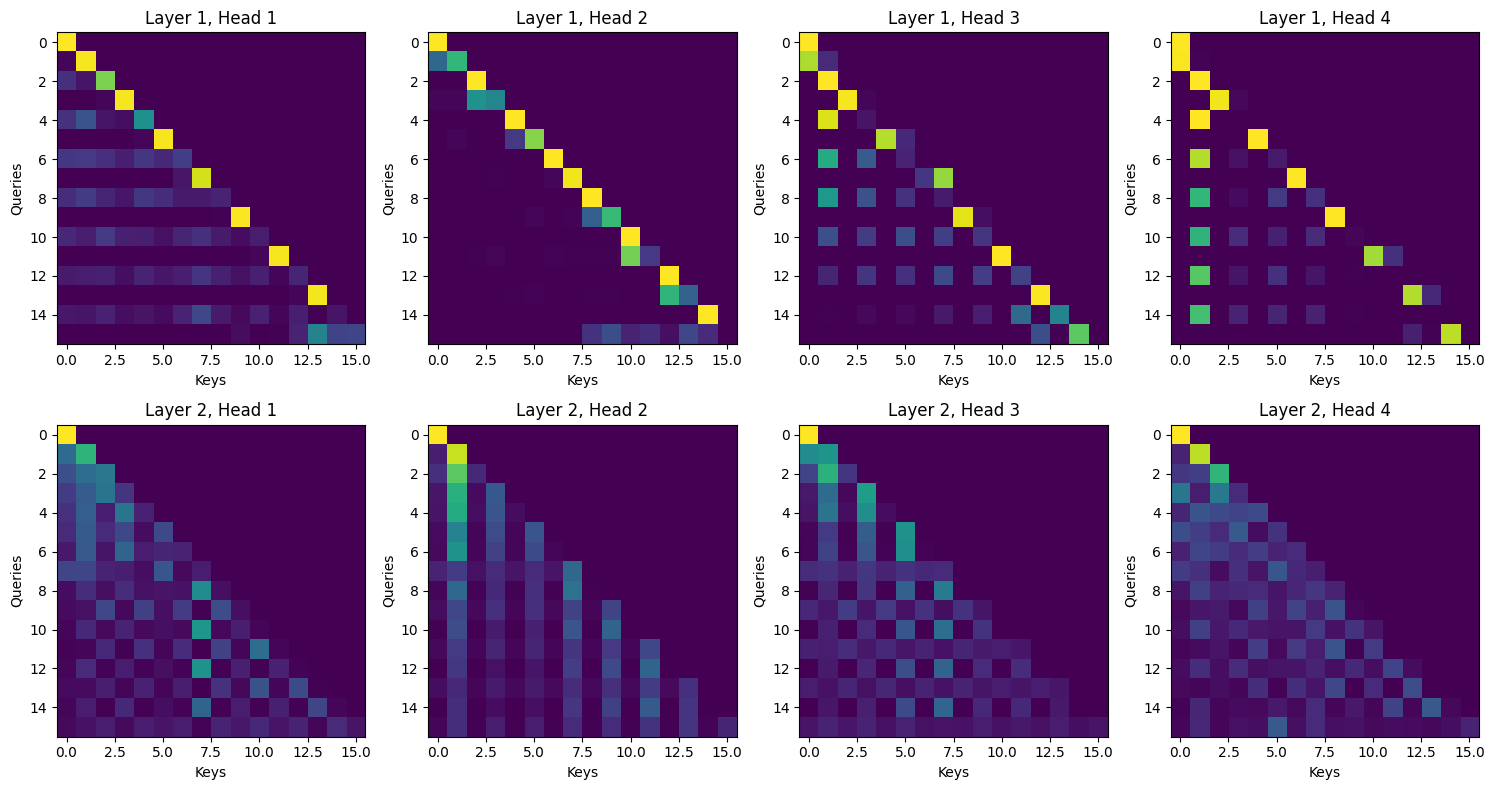

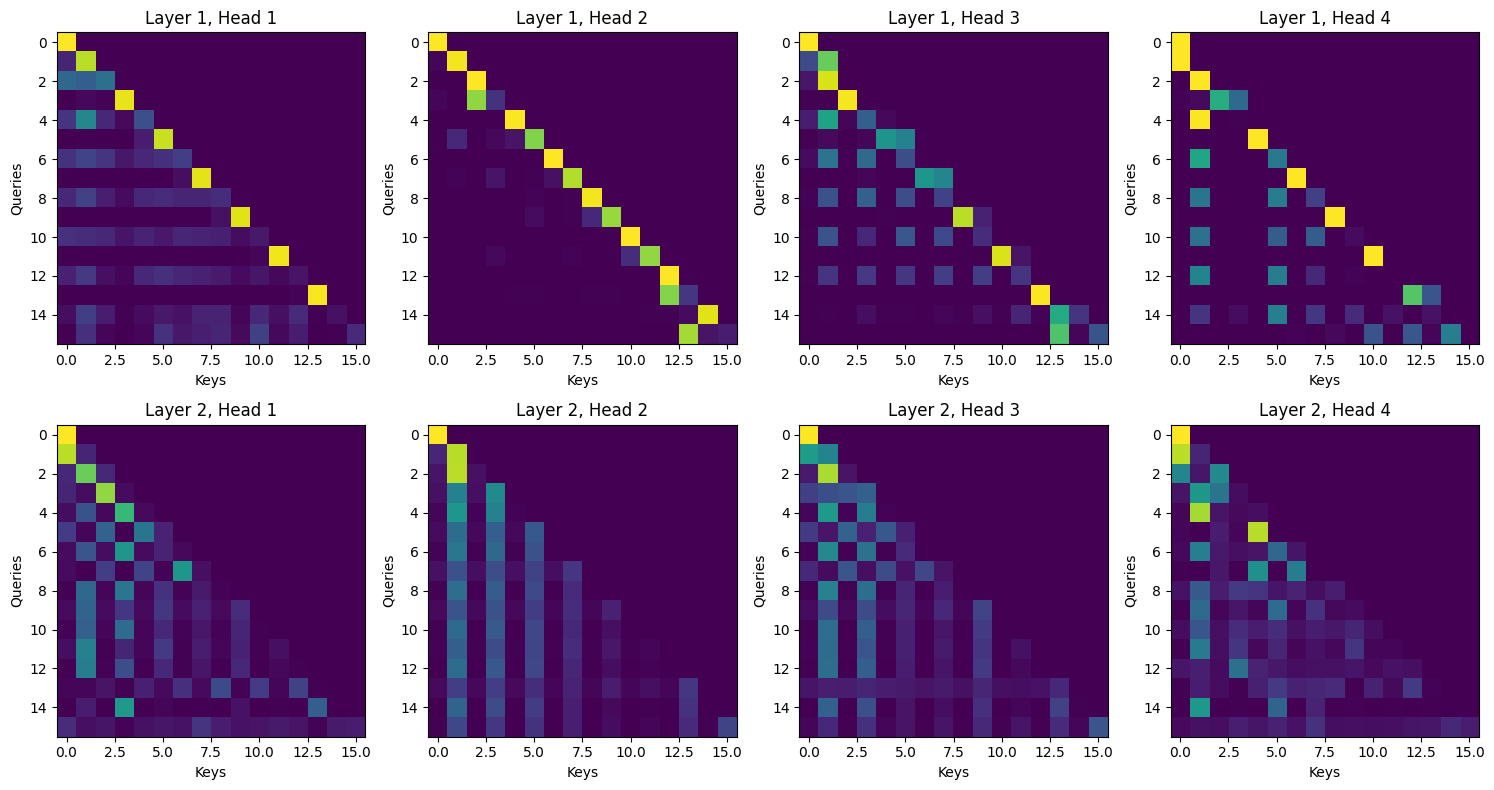

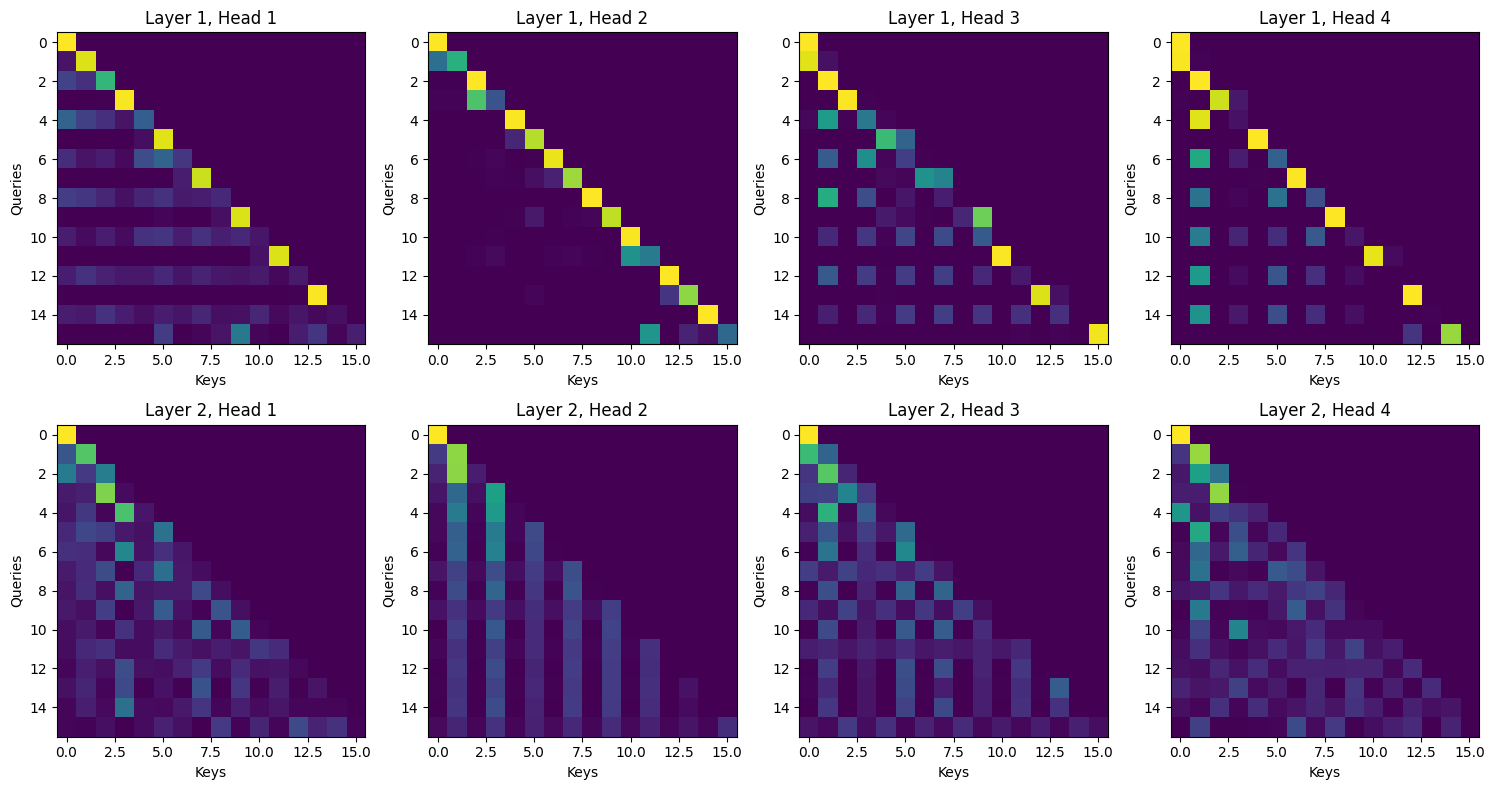

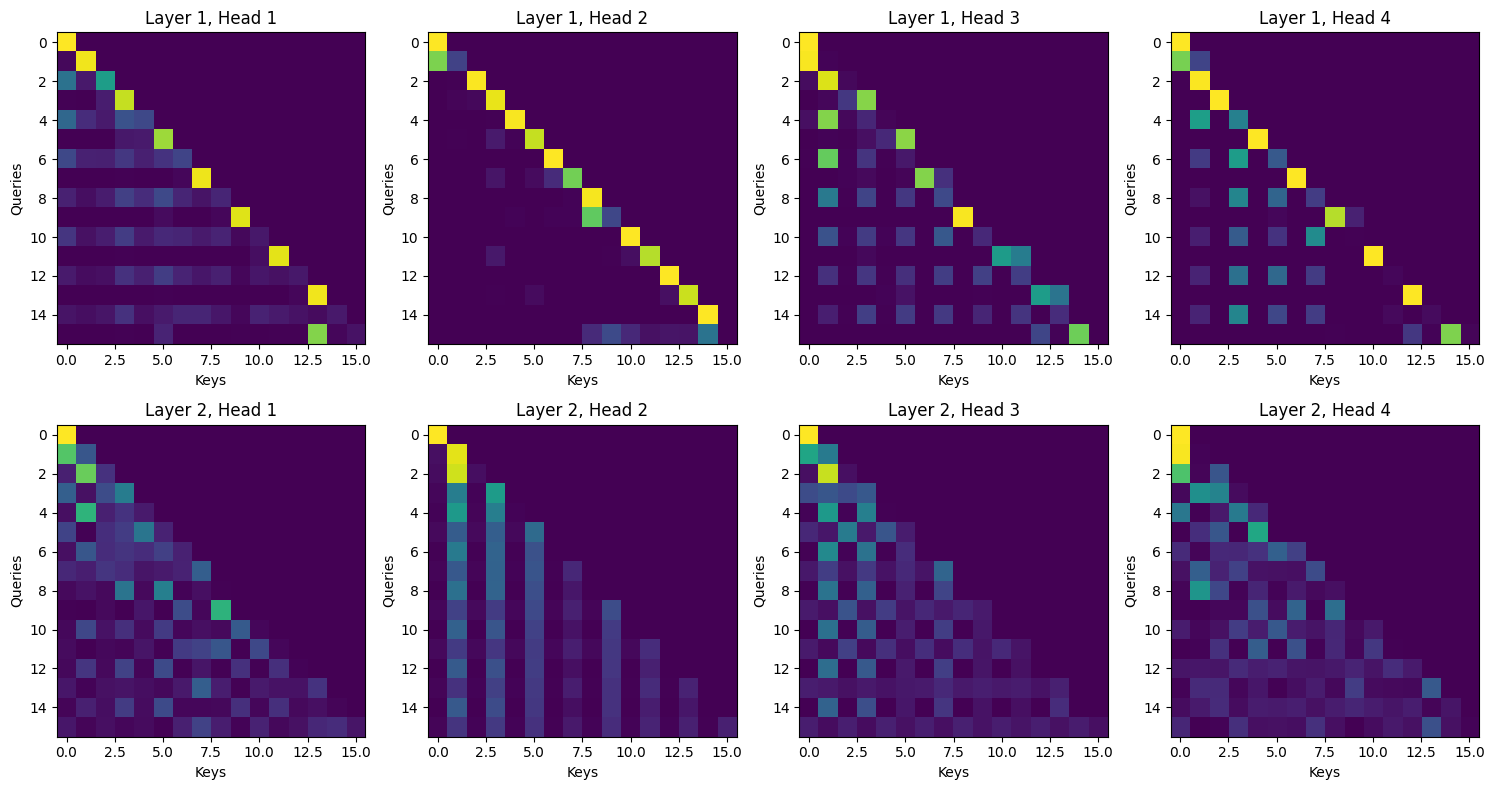

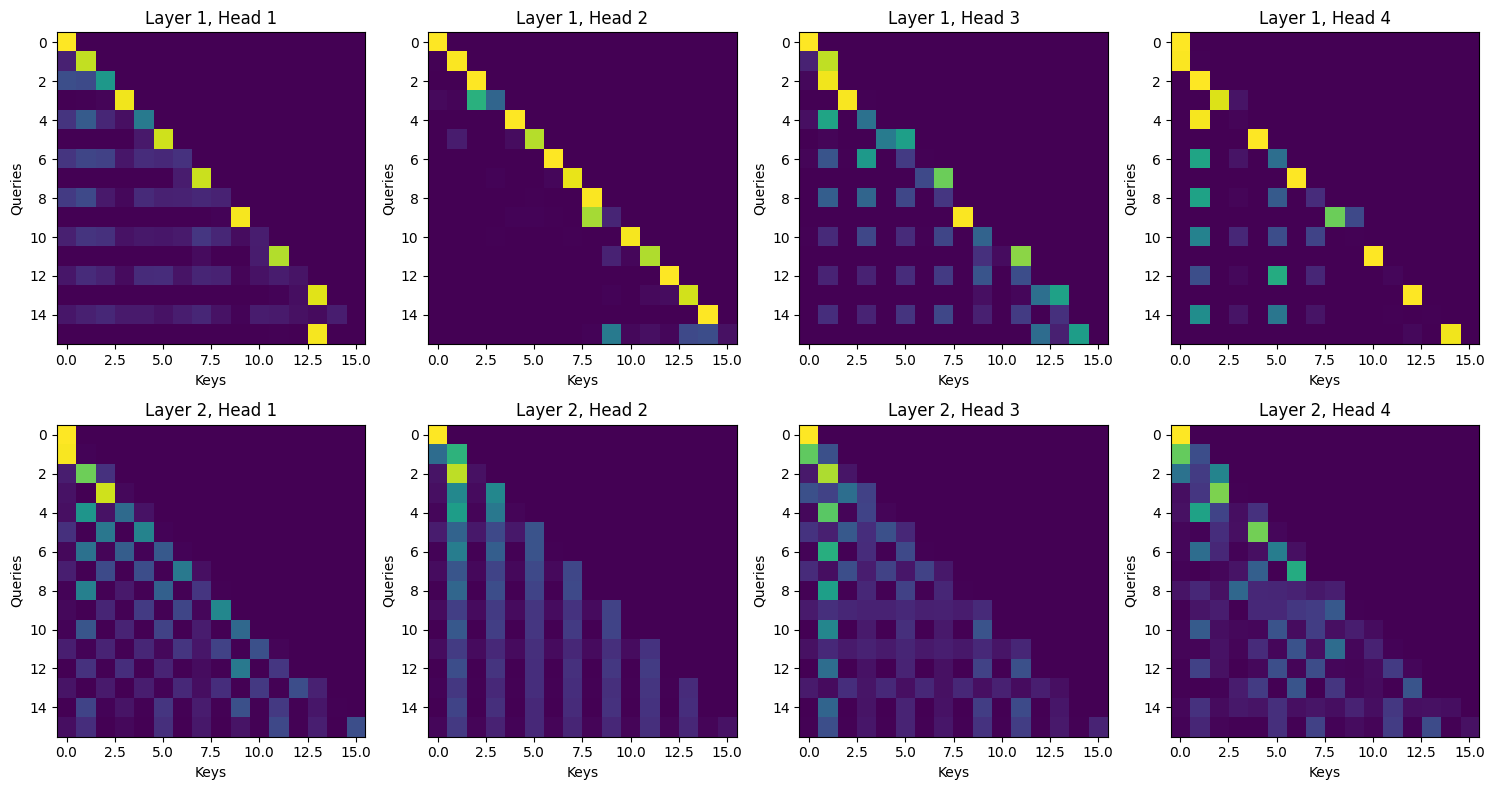

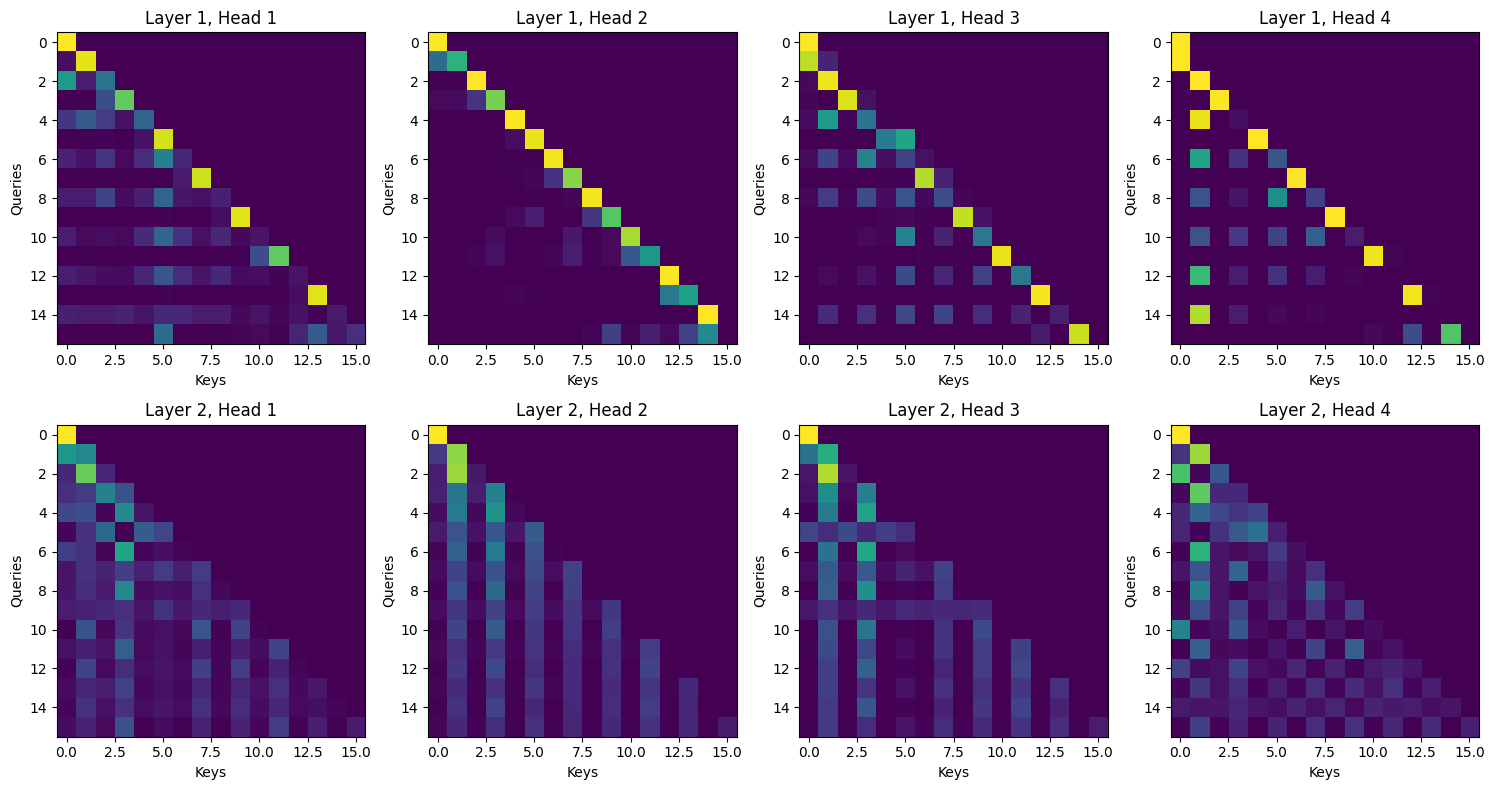

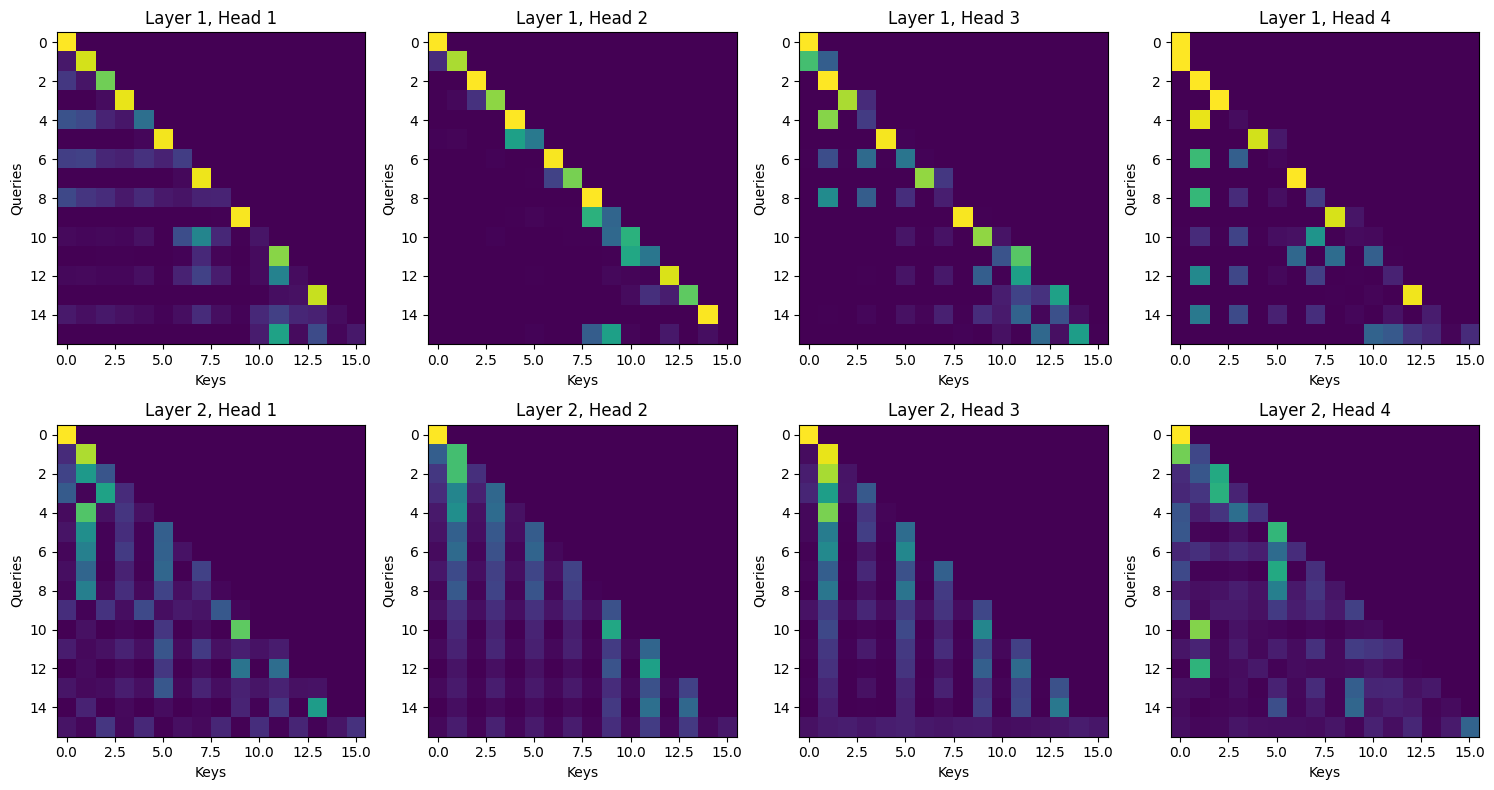

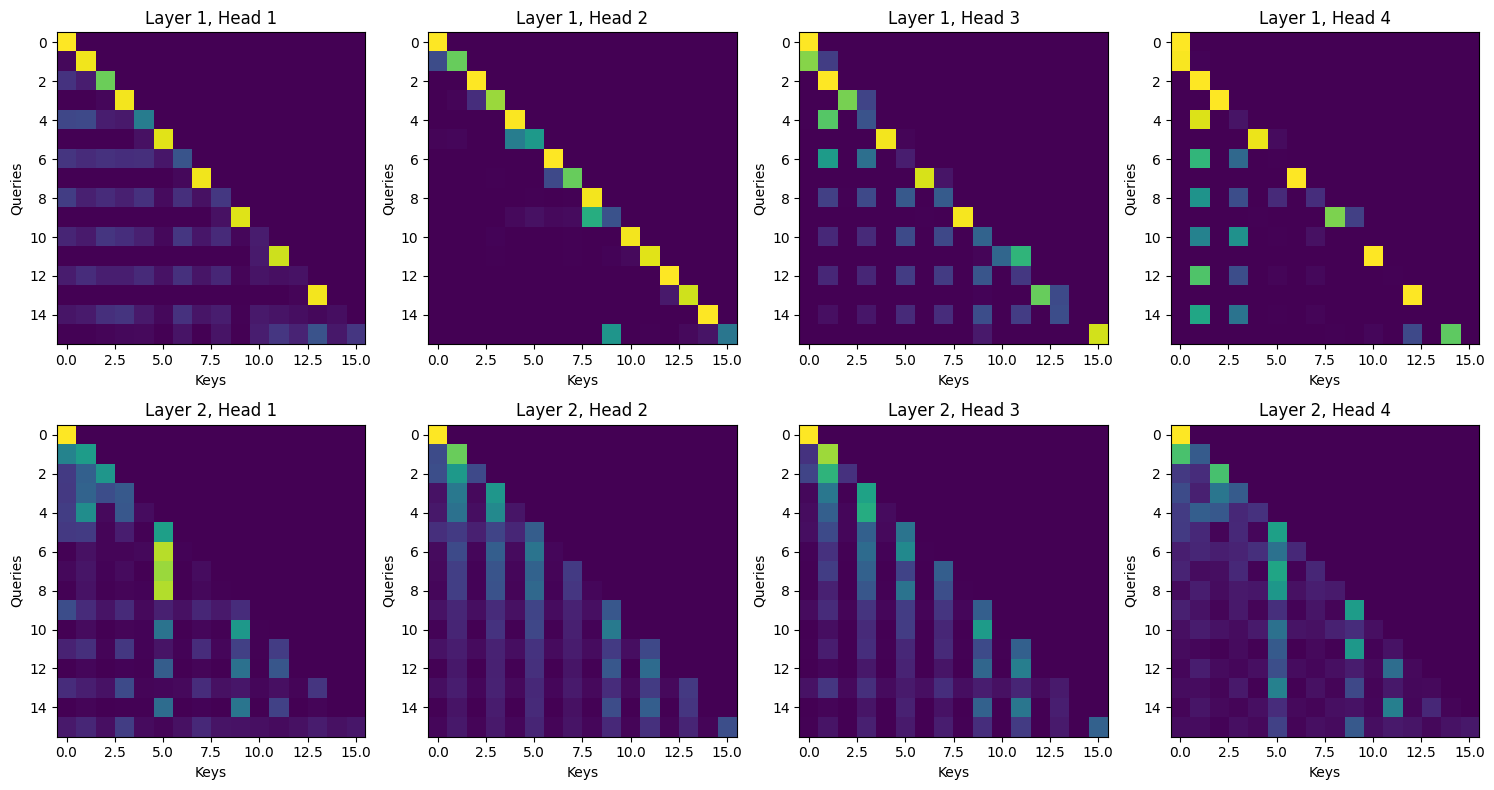

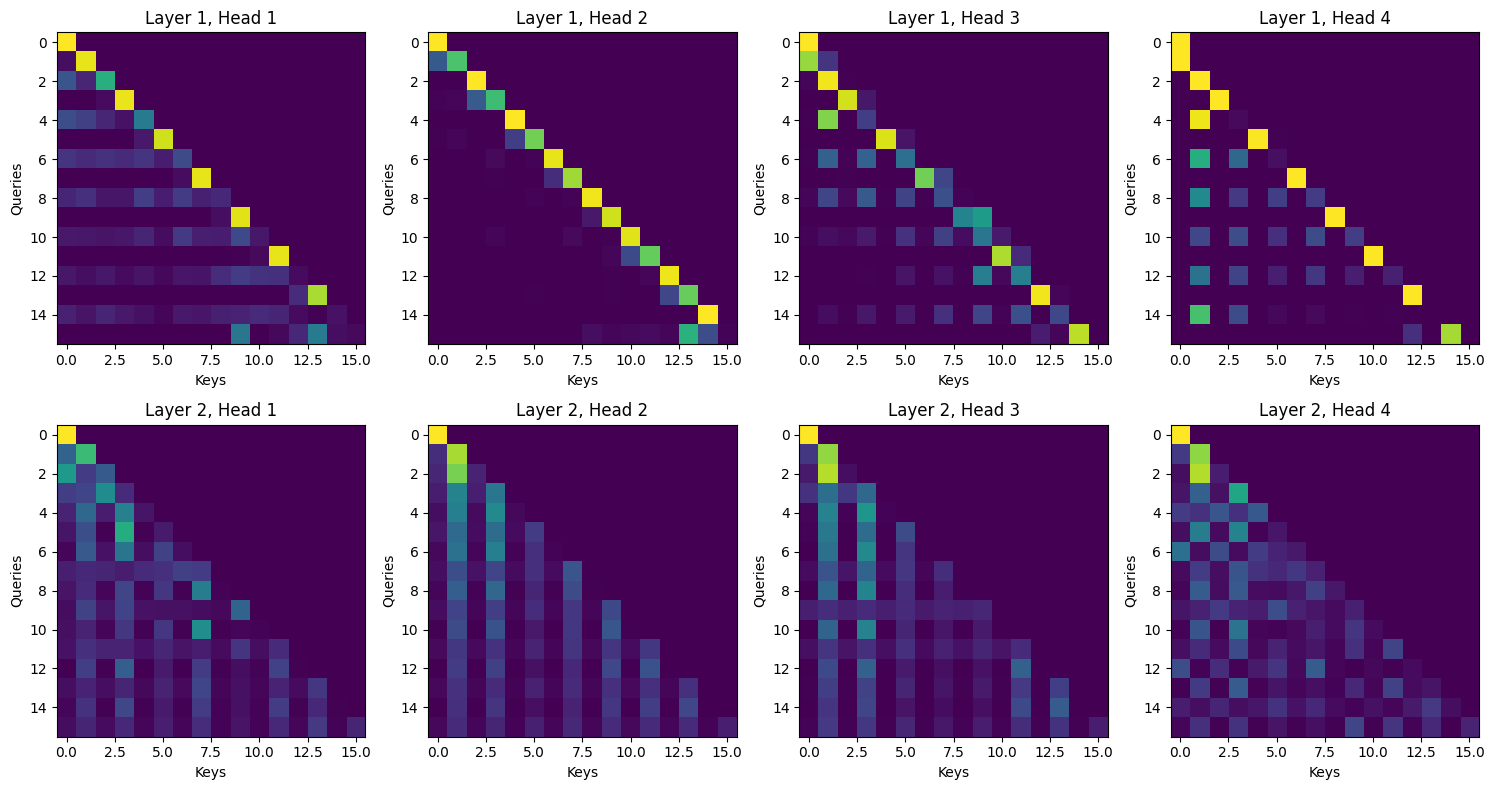

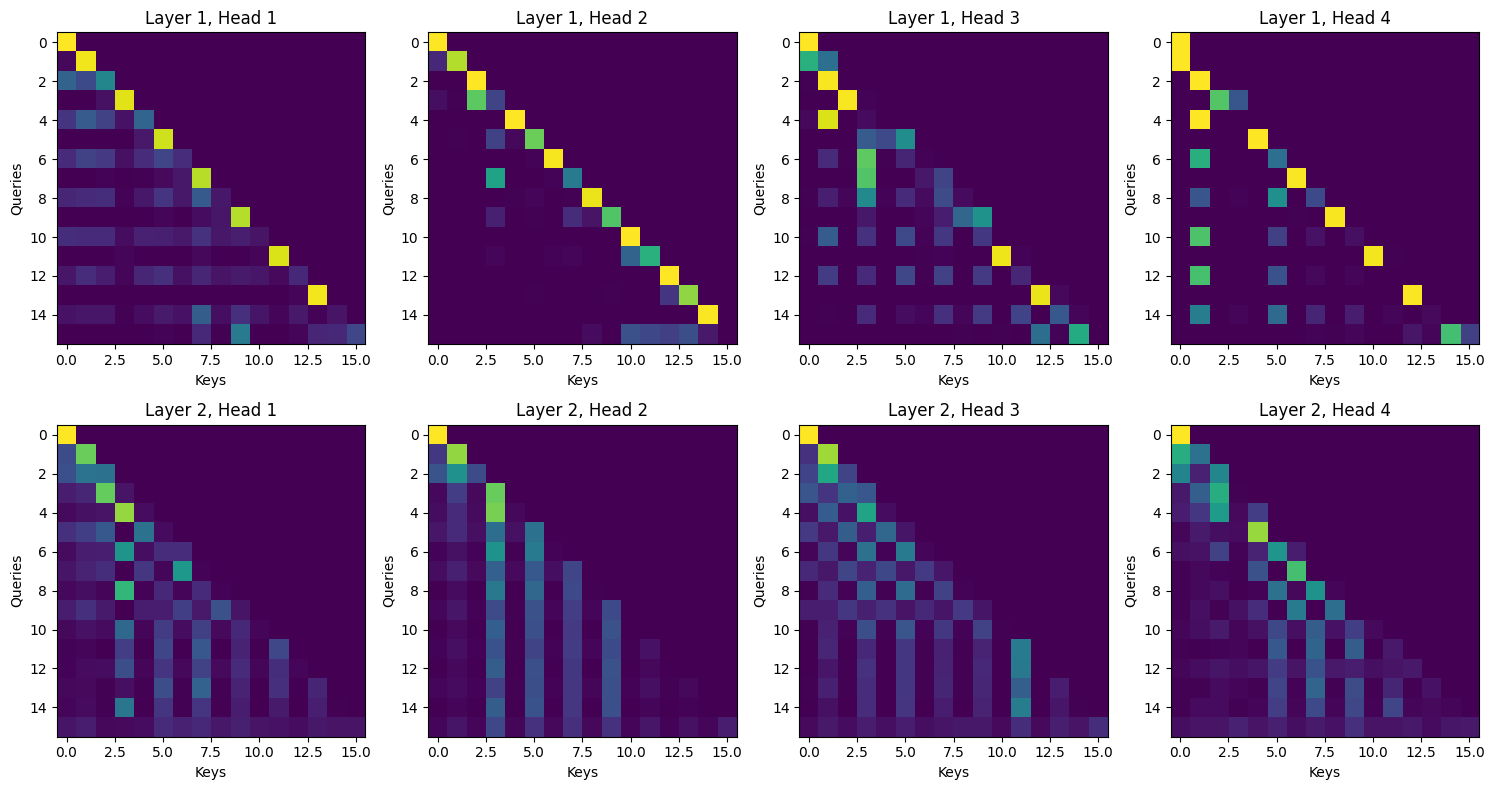

In [51]:
import matplotlib.pyplot as plt 

num_layers = 2
num_heads = 4

for sample_idx in range(10):
    # Create a new figure
    plt.figure(figsize=(15, 4 * num_layers))

    # Loop through each head
    for layer_idx, probe in enumerate(probes):
        for head_idx in range(num_heads):
            head_activation = probe.activation[sample_idx, head_idx].detach().cpu().numpy()

            # Create a subplot for each head
            ax = plt.subplot(num_layers, num_heads, layer_idx * num_heads + head_idx + 1)

            # Plot the activation
            ax.imshow(head_activation, cmap='viridis', aspect='auto')

            # Add title and labels
            ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
            ax.set_xlabel('Keys')
            ax.set_ylabel('Queries')

    plt.tight_layout()
    plt.show()